# Las losowy klasyfikacyjny

Wróćmy do problemu churn.

Zbiór danych: https://www.kaggle.com/datasets/mehmetsabrikunt/internet-service-churn

Tym razem nie będziemy dzielić zbioru na różne typy. Zobaczymy, czy stworzenie jednego modelu da nam dobre wyniki.

In [1]:
from  sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# puść ten kod, 
# jeżeli wywołujesz plik  w folderze rozwiąznaia, 
# a ramka danych znajduje się w folderze data
import os 
os.chdir('../')

In [3]:
# Pobranie danych
os.chdir('../')

df = pd.read_csv('data/internet_service_churn.csv')

In [3]:
# nagłówek
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [4]:
# dodanie zmiennej czy umowa terminow
df['is_fixed_term'] = (~(df['reamining_contract'].isna())).astype(int)

In [6]:
# kolumny X
x_names = [i for i  in df.columns[1:] if i!='churn']
x_names

['is_tv_subscriber',
 'is_movie_package_subscriber',
 'subscription_age',
 'bill_avg',
 'reamining_contract',
 'service_failure_count',
 'download_avg',
 'upload_avg',
 'download_over_limit',
 'is_fixed_term']

In [7]:
# Podział zbioru 

train_x, test_x, train_y, test_y = train_test_split(df[x_names],df['churn'], test_size=0.2, random_state=123)

In [8]:
# Podział zbioru na walidacyjny
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2,random_state=123)

## Optymalizacja modelu

Optymalizacja modelu polega na znalezieniu najlepszych parametrów (optymalizując przy tym wybraną metrykę ewaluacyjną).

W Pythonie jest dostępnych wiele bibliotek i funkcji, które wspomagają optymalizację. Będą one szerzej omawiane w bloku dotyczącym optymalizacji.

Aby dobrze zrozumieć proces optymalizacji, pierwszą napiszemy sami.

Najprostsza wersja optymalizacji, to przejście przez wszystkie wskazane parametry.

Dobrą praktyką (jeżeli posiadamy dostatecznie duży zbiór danych) jest wydzielenie zbioru walidacyjnego. Na zbiorze testowym wybierzemy najlepsze parametry i potwierdzimy je na zbiorze walidacyjnym.

In [21]:
# Optymalizacja dwóch parametrów:
max_depth = [3,10,20]
n_estimators = [50,100,500]

best_score = None
best_params = {}
best_model = None
for md in max_depth:
    for ne in n_estimators:
        model = RandomForestClassifier(max_depth=md, n_estimators=ne, min_samples_leaf=10).fit(train_x,train_y)
        score = model.score(test_x, test_y)
        if best_score is None or best_score < score:
            best_score = score
            best_params = {'max_depth': md, 'n_estimators': ne}
            best_model = model
        print(f'End of iteration. The best score is equal to {best_score}')



End of iteration. The best score is equal to 0.9319266689726738
End of iteration. The best score is equal to 0.9319266689726738
End of iteration. The best score is equal to 0.9324109304738845
End of iteration. The best score is equal to 0.9375994465582843
End of iteration. The best score is equal to 0.9375994465582843
End of iteration. The best score is equal to 0.9375994465582843
End of iteration. The best score is equal to 0.9386371497751643
End of iteration. The best score is equal to 0.9386371497751643
End of iteration. The best score is equal to 0.9386371497751643


### Ewaluacja modelu
Ocenę przeprowadzimy na zbiorze walidacyjnym.

In [10]:
# Stworzymy zmienną z typem umowy
def type_of_agreement(time_to_end, threshold=90.0/365):
    if np.isnan(time_to_end):
        return 'indefinite'
    elif time_to_end <=threshold:
        return 'ending soon'
    else: 
        return 'long time to end'


In [22]:
# train 
train = train_x.copy()
train['churn'] = train_y.copy()
train['type'] = train.loc[:,'reamining_contract'].apply(lambda x: type_of_agreement(x))
train['pred'] = best_model.predict(train[best_model.feature_names_in_])
train['pred_proba'] = best_model.predict_proba(train[best_model.feature_names_in_])[:,1]

In [23]:
# test
test = test_x.copy()
test['churn'] = test_y.copy()
test['type'] = test.loc[:,'reamining_contract'].apply(lambda x: type_of_agreement(x))
test['pred'] = best_model.predict(test[best_model.feature_names_in_])
test['pred_proba'] = best_model.predict_proba(test[best_model.feature_names_in_])[:,1]

In [24]:
# valid
valid = valid_x.copy()
valid['churn'] = valid_y.copy()
valid['type'] = valid.loc[:,'reamining_contract'].apply(lambda x: type_of_agreement(x))
valid['pred'] = best_model.predict(valid[best_model.feature_names_in_])
valid['pred_proba'] = best_model.predict_proba(valid[best_model.feature_names_in_])[:,1]

In [27]:
# Pole pod krzywą roc
auc_train = round(roc_auc_score(train['churn'],train['pred_proba']),3)
auc_test = round(roc_auc_score(test['churn'],test['pred_proba']),3)
auc_valid = round(roc_auc_score(valid['churn'],valid['pred_proba']),3)
print(f'AUC train: {auc_train}, AUC test: {auc_test}, AUC valid: {auc_valid}')

AUC train: 0.992, AUC test: 0.98, AUC valid: 0.98


In [28]:
# Przygotwanie danych do wykresu
fpr_train ,tpr_train, thresholds_train = roc_curve(train['churn'],train['pred_proba'])
fpr_test ,tpr_test, thresholds_test = roc_curve(test['churn'],test['pred_proba'])
fpr_valid ,tpr_valid, thresholds_valid = roc_curve(valid['churn'],valid['pred_proba'])



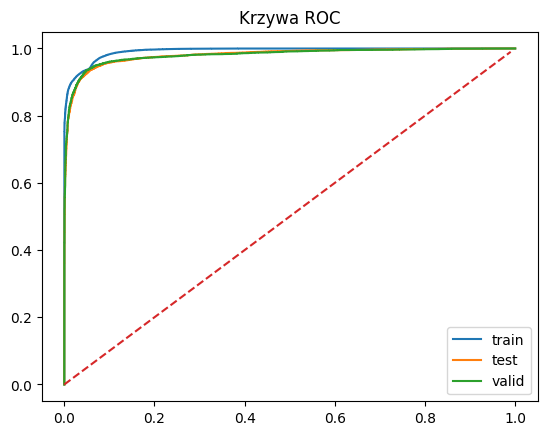

In [29]:
# Wykres
plt.plot(fpr_train, tpr_train, label='train')
plt.plot(fpr_test,tpr_test, label = 'test')
plt.plot(fpr_valid,tpr_valid, label='valid')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')
plt.legend()
plt.title('Krzywa ROC')
plt.show()

#### Ocena modelu w grupach

In [30]:
train.type.unique()

array(['soon ending', 'indefinite', 'long time to end'], dtype=object)

In [31]:
# Pole pod krzywą roc
for i in train.type.unique():
    print(f'Results for {i}')
    auc_train = round(roc_auc_score(train.loc[train['type']==i,'churn'],train.loc[train['type']==i,'pred_proba']),3)
    auc_test = round(roc_auc_score(test.loc[test['type']==i,'churn'], test.loc[test['type']==i,'pred_proba']),3)
    auc_valid = round(roc_auc_score(valid.loc[valid['type']==i,'churn'],valid.loc[valid['type']==i,'pred_proba']),3)
    print(f'AUC train: {auc_train}, AUC test: {auc_test}, AUC valid: {auc_valid}')
    print('\n')



Results for soon ending
AUC train: 0.999, AUC test: 0.994, AUC valid: 0.993


Results for indefinite
AUC train: 0.952, AUC test: 0.89, AUC valid: 0.892


Results for long time to end
AUC train: 0.973, AUC test: 0.868, AUC valid: 0.854


